In [43]:
###############cnn with batch normalization
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
import pandas as pd
%matplotlib inline


#####importing data
from sklearn.datasets import fetch_mldata #import data
mnist = fetch_mldata('MNIST original')

A_prev = mnist.data
Y = mnist.target
A_prev = A_prev[0:1000,:]
Y = np.array(Y)
Y = Y[0:1000]
Y = Y.reshape(1000,1)
Y = Y.astype(int)



In [3]:
#########support functions

def softmax(Z):
    ps = np.exp(Z)
    ps = ps/float(np.sum(ps))
    return ps

def relu(Z):
    return np.multiply(Z,Z>0)


def softmax_backprop (dA , A_prev):
    avg = np.sum(A_prev,axis = 0)
    numrtr = A_prev.dot(avg - A_prev)
    dnmntr = np.square(avg)
    dA_prev = np.multiply(dA,np.divide(numrtr,dnmntr))
    return dA_prev




def flatten_a_data(X):
    (m,a,b,c) = X.shape #no of training example
    X = np.reshape(X,(m,a*b*c))
    return X

def loss(A,Y):
    (m,n) = Y.shape
    return -np.sum(np.multiply(np.log(A),Y))/m


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [4]:
######convolution and pooling functions

def zero_pad(X, pad):
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad



def conv_single_step(a_slice_prev, W, b):

  
    
    s = np.multiply(a_slice_prev,W)
  
    Z = np.sum(s,axis=None)
  
    Z = Z + float(b)
   

    return Z


In [5]:
def conv_forward(A_prev, W, b, hparameters):
    
    
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
   
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume
    n_H = int((n_H_prev-f+2*pad)/stride)  +1
    n_W = int((n_W_prev-f+2*pad)/stride) +1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m,n_H,n_W,n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                   # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = h*stride+f
                    horiz_start = w*stride
                    horiz_end = w*stride+f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = a_prev_pad[vert_start:vert_end ,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


In [22]:
def pool_forward(A_prev, hparameters, mode = "max"):
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
   
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = h*stride+f
                    horiz_start = w*stride
                    horiz_end = w*stride+f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i,vert_start:vert_end ,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    
    
    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


In [23]:
def conv_backward(dZ, cache):
    
   
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db =np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w * stride
                    horiz_end = w*stride + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters 
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:,pad:,:]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db



In [24]:
def create_mask_from_window(x):
    
    ### START CODE HERE ### (≈1 line)
    mask = np.full((x.shape),False,dtype=bool)
    ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
    mask[ind]=True
    ### END CODE HERE ###
    
    return mask





In [25]:
def pool_backward(dA, cache, mode = "max"):
    
   
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_pre
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) 
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask,dA[i,h,w,c])
                        
                   

    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [10]:
def batchnorm_forward(x, gamma, beta, eps):  ####taken help from blog
    N, D = x.shape

  #step1: calculate mean
    mu = 1./N * np.sum(x, axis = 0)

  #step2: subtract mean vector of every trainings example
    xmu = x - mu

  #step3: following the lower branch - calculation denominator
    sq = xmu ** 2

  #step4: calculate variance
    var = 1./N * np.sum(sq, axis = 0)

  #step5: add eps for numerical stability, then sqrt
    sqrtvar = np.sqrt(var + eps)

  #step6: invert sqrtwar
    ivar = 1./sqrtvar

  #step7: execute normalization
    xhat = xmu * ivar

  #step8: Nor the two transformation steps
    gammax = gamma * xhat

  #step9
    out = gammax + beta

  #store intermediate
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
    return out, cache


In [11]:
def batchnorm_backward(dout, cache):
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
    #get the dimensions of the input/output
    N,D = dout.shape

  #step9
    dbeta = np.sum(dout, axis=0)
    dgammax = dout #not necessary, but more understandable

  #step8
    dgamma = np.sum(dgammax*xhat, axis=0)
    dxhat = dgammax * gamma

  #step7
    divar = np.sum(dxhat*xmu, axis=0)
    dxmu1 = dxhat * ivar

  #step6
    dsqrtvar = -1. /(sqrtvar**2) * divar

  #step5
    dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

  #step4
    dsq = 1. /N * np.ones((N,D)) * dvar

  #step3
    dxmu2 = 2 * xmu * dsq

  #step2
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

  #step1
    dx2 = 1. /N * np.ones((N,D)) * dmu

  #step0
    dx = dx1 + dx2

    return dx, dgamma, dbeta

In [45]:
###y one hot encoding
Y = convert_to_one_hot(Y,10)

In [13]:
def reshape (A_prev):            #reshape input to (m,n_H,n_W,n_C)
    X_layer = list()
    for m in (A_prev):
        X_layer.append(m.reshape(28,28))
    X_layer = np.array(X_layer)
    X_layer.shape  
    X_layer = X_layer.reshape(X_layer.shape[0],X_layer.shape[1],X_layer.shape[2],1)
    X_layer.shape
    return X_layer

In [14]:
A_prev = reshape(A_prev)
(m,n_H,n_W,n_C_prev)=A_prev.shape
f = 3                           # no. of filters
n_C_prev = 1                    #grey scale image

In [15]:
W = np.random.randn(f,f,n_C_prev,10)*0.01   #initialise filters

In [16]:
b = np.random.randn(1,1,1,10)*0.01       #initialise biase

In [17]:
hparameters_conv = {"pad" : 0,          #initialise hparameters for convolution
               "stride": 3}

In [18]:
hparameters_pool = {"f" : 3,            #initialise hparameters for pooling
                    "stride" : 1}

In [19]:
W_fc = np.random.randn(10,490)*0.01     #initialise weights for FC layer
b_fc = np.random.rand(1000,10)*0.01     #initialise bias for biase
lr = 0.01                               #learning rate 
epochs = 10                     #No. of epochs
cost = np.zeros(epochs  )   

#Initialise
gamma = 1
beta = 0
epsilon = 0.0001

In [21]:
for i in range(epochs):
    A, cache_conv = conv_forward(A_prev, W, b, hparameters_conv) #compute convolution
    A1 ,cache_pool = pool_forward(A,hparameters_pool,mode = "max") #compute pooling
    A2 = flatten_a_data(A1) #convert to fc layer
    Z_fc = A2.dot(W_fc.T) +b_fc 
    Z_batch_normalize,cache_norm = batchnorm_forward(Z_fc,gamma,beta,epsilon)

    A3 = softmax(Z_batch_normalize)              #apply softmax
    cost[i] = loss(A3,Y)            #compute cost
    dZ_fc = A3-Y  
    d_batch,dgamaa,dbeta = batchnorm_backward(dZ_fc, cache_norm)
    dW_fc = d_batch.T.dot(A2)
    db_fc = dZ_fc
    
    dA2 = np.dot(dZ_fc,W_fc)
   
   
    
    
    dA = pool_backward(A1 , cache_pool,mode = "max" )
    dA_prev , dW , db = conv_backward(dA,cache_conv)
    
    W_fc = W_fc - dW_fc*lr
    b_fc = b_fc - db_fc*lr
    A2 = A2 - dA2*lr
    A = A - dA*lr
    W = W - dW*lr
    b = b - db*lr
    gamma = gamma - lr*dgamaa
    beta = beta - lr*dbeta
    A1 = np.reshape(A2,(1000,7,7,10))
    print (cost[i])
    
    
    

9.656730293194382
9.875061846646274
7.24498344836504
7.072959568476159
7.240604312362037
7.070639604557852
7.234723573847317
7.068377173592964
7.228983791333231
7.0661248779513715


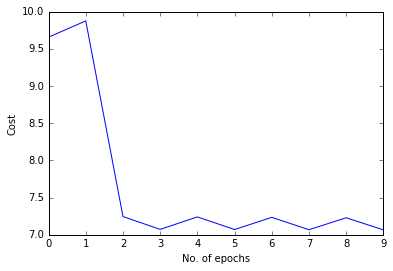

In [28]:
import matplotlib.pyplot as plt      
%matplotlib inline 
# plot Cost vs no. of iterarions
plt.plot(np.arange(len(cost)),cost)
plt.xlabel("No. of epochs")
plt.ylabel("Cost")
plt.show()

In [30]:
########accuracy



#finallll_prediction = np.array(total_predictions[-100:])
#output_original = X_label[0:100]

#test_confusion = confusion_matrix(output_original,finallll_prediction)
#test_confusion.view()

(1000, 10)

In [42]:
from sklearn.metrics import confusion_matrix
final_pred = []
A3
for m in range(A3.shape[0]) :
    final_pred.append(A3[m].argmax())
final_pred =  np.array(final_pred)

###output
Y_output = mnist.target

Y_output = np.array(Y_output)
Y_output = Y_output[0:1000]
Y_output = Y_output.reshape(1000,1)

test_confusion = confusion_matrix(Y_output,final_pred)



array([[1000]])

In [47]:
p = np.zeros((A3.shape))
count = 0
for i in range (1000):
   j = np.unravel_index(A3[i].argmax(), A3[i].shape)
   if Y[i][j] == 1. :
       count = count + 1
accuracy = count / float(1000)
print (accuracy*100)

100.0
